In [1]:
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
import tensorflow_probability as tfp

In [31]:
# name = 'PL=F' #platinum
# name = 'GC=F' #gold
# name = 'SI=F' #silver
# name = 'HG=F' #copper
# name = 'PA=F' #paladium
# name = 'CL=F' #crude oil
# name = 'BZ=F' #brent crude oil
name = 'NG=F' #natural gas

train_end_date = '2023-07-01'

name_ohlc_df = yf.download(name, start='2010-01-01', end=train_end_date)
name_ohlc_df = name_ohlc_df.reset_index()

data = {'date': name_ohlc_df.Date, 'close': name_ohlc_df.Close}
df = pd.DataFrame(data)
df.head()

[*********************100%***********************]  1 of 1 completed


,date,close
0,2010-01-04,4.6225
1,2010-01-05,4.6900
2,2010-01-06,4.7200
3,2010-01-07,4.6275
4,2010-01-08,4.6375


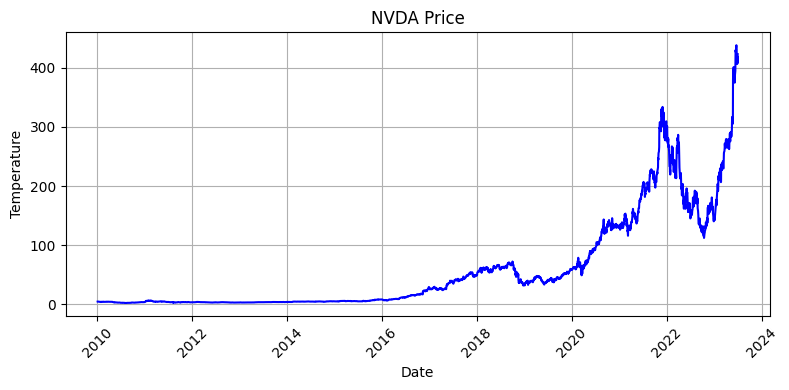

In [32]:
plt.figure(figsize=(8, 4))
plt.plot(df['date'], df['close'], linestyle='-', color='b')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title(name+' Price')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
# x1 = np.array(df.iloc[:,1]+np.random.randn(df.shape[0])).astype(np.float32).reshape(-1,1)
train_size = int(0.75 * len(df))

# x1 = np.array(df.iloc[:train_size,1]).astype(np.float32).reshape(-1,1)
sequence_length = 10
train_input = np.lib.stride_tricks.sliding_window_view(df.iloc[:train_size,1].values, sequence_length)
val_input = np.lib.stride_tricks.sliding_window_view(df.iloc[train_size:-1,1].values, sequence_length)

y1 = np.array(df.iloc[sequence_length:train_size+1,1]).T.astype(np.float32).reshape(-1,1)
y2 = np.array(df.iloc[sequence_length+train_size:,1]).T.astype(np.float32).reshape(-1,1)

tfd = tfp.distributions

In [34]:
# print(train_input[:2])
# print()
# print(y1[:2])
# print(train_input.shape,y1.shape)

print(val_input[:2])
print()
print(y2[:2])
print(val_input.shape,y2.shape)

[[74.14250183 78.67500305 77.17500305 73.51750183 68.31999969 65.51249695
  66.91249847 63.15000153 67.51750183 69.10749817]
 [78.67500305 77.17500305 73.51750183 68.31999969 65.51249695 66.91249847
  63.15000153 67.51750183 69.10749817 66.47250366]]

[[66.4725]
 [71.1275]]
(839, 10) (839, 1)


In [35]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  c = np.log(np.expm1(1.))
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t[..., :n],
                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
          reinterpreted_batch_ndims=1)),
  ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
  n = kernel_size + bias_size
  return tf.keras.Sequential([
      tfp.layers.VariableLayer(n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(
          tfd.Normal(loc=t, scale=1),
          reinterpreted_batch_ndims=1)),
  ])


In [36]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(32,activation='relu'),
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/train_input.shape[0]),
  tfp.layers.DistributionLambda(
      # lambda t: tfd.Normal(loc=t[..., :1],scale=1e-3 + tf.math.softplus(0.001 * t[...,1:]))),
      lambda t: tfd.StudentT(df=4,loc=t[..., :1],scale=1e-3 + 0.001*tf.math.softplus(t[...,1:]))),
      # lambda t: tfd.TwoPieceStudentT(df=5,loc=t[..., :1],scale=1e-3 + 0.1*tf.math.softplus(t[...,1:2]),skewness=0.1 + 0.1*tf.math.softplus(t[...,2:]))),

])

In [37]:
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

# Do inference.
model.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.01), loss=negloglik)
model.fit(train_input, y1, epochs=1500, verbose=1);


Epoch 1/1500
80/80 [==============================] - 1s 674us/step - loss: 29.1817
Epoch 2/1500
80/80 [==============================] - 0s 560us/step - loss: 25.8959
Epoch 3/1500
80/80 [==============================] - 0s 533us/step - loss: 25.6607
Epoch 4/1500
80/80 [==============================] - 0s 549us/step - loss: 21.2758
Epoch 5/1500
80/80 [==============================] - 0s 525us/step - loss: 21.7492
Epoch 6/1500
80/80 [==============================] - 0s 552us/step - loss: 19.9664
Epoch 7/1500
80/80 [==============================] - 0s 1ms/step - loss: 20.1746
Epoch 8/1500
80/80 [==============================] - 0s 487us/step - loss: 18.6527
Epoch 9/1500
80/80 [==============================] - 0s 548us/step - loss: 19.0634
Epoch 10/1500
80/80 [==============================] - 0s 573us/step - loss: 18.0546
Epoch 11/1500
80/80 [==============================] - 0s 556us/step - loss: 16.1816
Epoch 12/1500
80/80 [==============================] - 0s 1ms/step - loss: 1

In [38]:
# Profit.
yhat = model(val_input)
# [print(np.squeeze(w.numpy())) for w in model.weights];
assert isinstance(yhat, tfd.Distribution)

In [39]:
yhats = [model(val_input) for _ in range(100)]
for i, yhat in enumerate(yhats):
  m = np.squeeze(yhat.mean())
  s = np.squeeze(yhat.stddev())

(839, 1) (839, 1) (839,)


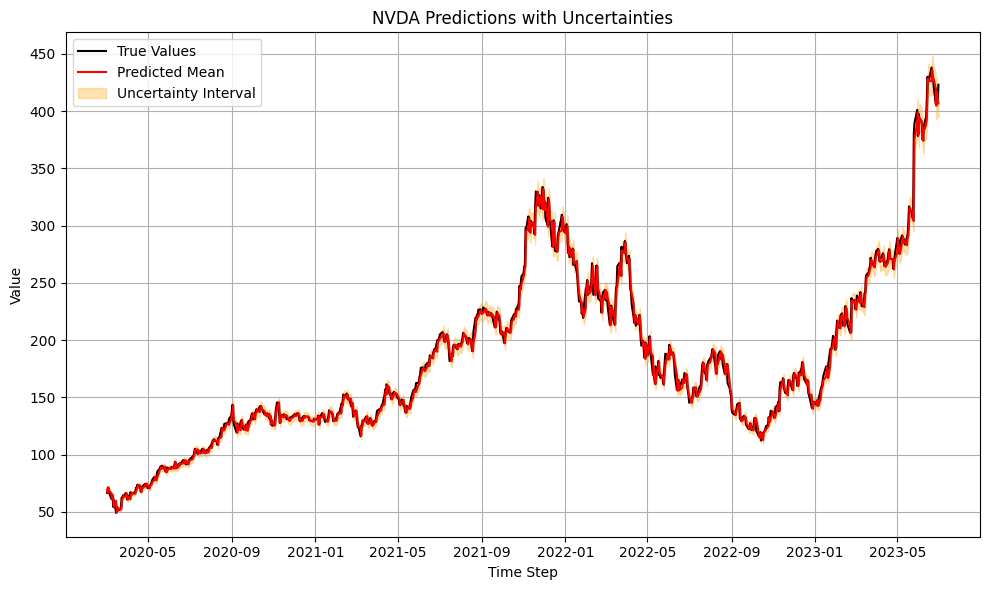

In [40]:
val_dates = np.array(df.iloc[sequence_length+train_size:,0]).T.reshape(-1,1)
print(val_dates.shape,y2.shape,m.shape)
upper_bound = m + s
lower_bound = m - s

plt.figure(figsize=(10, 6))
plt.plot(val_dates,y2, label='True Values', color='black')
plt.plot(val_dates,m, label='Predicted Mean', color='red')
plt.fill_between(val_dates.reshape(-1), lower_bound, upper_bound, color='orange', alpha=0.3, label='Uncertainty Interval')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title(f'{name} Predictions with Uncertainties')
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.xlim((val_dates[50][0],val_dates[350][0]))
plt.show()

(70, 10) (70, 1) (70, 1) (70,)


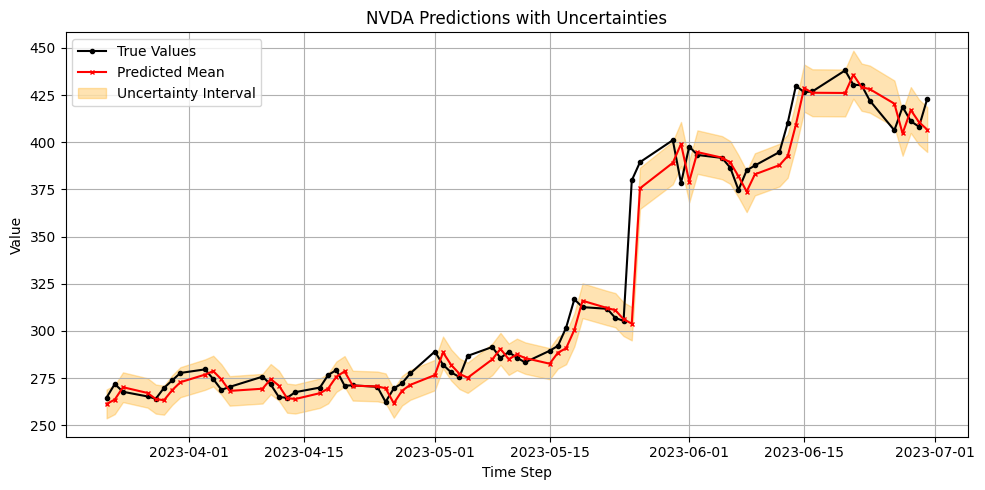

In [52]:
test_size = -80
test_input = np.lib.stride_tricks.sliding_window_view(df.iloc[test_size:-1,1].values, sequence_length)
y3 = np.array(df.iloc[sequence_length+test_size:,1]).T.astype(np.float32).reshape(-1,1)
y3shift = np.roll(y3, shift=1)
y3shift[0] = np.nan
test_dates = np.array(df.iloc[sequence_length+test_size:,0]).T.reshape(-1,1)

yhats_test = [model(test_input) for _ in range(100)]

for i, yhat in enumerate(yhats_test):
  m_test = np.squeeze(yhat.mean())
  s_test = np.squeeze(yhat.stddev())

print(test_input.shape,y3.shape,test_dates.shape,m_test.shape)
upper_bound = m_test + s_test
lower_bound = m_test - s_test

plt.figure(figsize=(10,5))
plt.plot(test_dates, y3, label='True Values', color='black',marker='o',markersize=3)
plt.plot(test_dates, y3shift, label='Shift Values', color='grey')
plt.plot(test_dates, m_test, label='Predicted Mean', color='red',marker='x',markersize=3)
plt.fill_between(test_dates.reshape(-1), lower_bound, upper_bound, color='orange', alpha=0.3, label='Uncertainty Interval')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title(f'{name} Predictions with Uncertainties')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_mape(true_data, forecast_data):
    absolute_percentage_errors = np.abs((true_data - forecast_data) / true_data)
    mape = np.mean(absolute_percentage_errors) * 100
    return mape

def calculate_rmse(true_data, forecast_data):
    rmse = np.sqrt(mean_squared_error(true_data, forecast_data))
    return rmse

def calculate_mae(true_data, forecast_data):
    mae = mean_absolute_error(true_data, forecast_data)
    return mae

def calculate_r2(true_data, forecast_data):
    r2 = r2_score(true_data, forecast_data)
    return r2

def calculate_forecast_bias(true_data, forecast_data):
    forecast_bias = np.mean(forecast_data - true_data)
    return forecast_bias


mape = calculate_mape(y3, m_test)
rmse = calculate_rmse(y3, m_test)
mae = calculate_mae(y3, m_test)
fb = calculate_forecast_bias(y3, m_test)
r2 = calculate_r2(y3, m_test)
print("MAPE:", mape,'\nRMSE:',rmse,'\nMAE:',mae,'\nFB:',fb,'\nR2:',r2)
print()
mape = calculate_mape(y3, np.nan_to_num(y3shift,nan=0.0))
rmse = calculate_rmse(y3, np.nan_to_num(y3shift,nan=0.0))
mae = calculate_mae(y3, np.nan_to_num(y3shift,nan=0.0))
fb = calculate_forecast_bias(y3, np.nan_to_num(y3shift,nan=0.0))
r2 = calculate_r2(y3, np.nan_to_num(y3shift,nan=0.0))
print("MAPE:", mape,'\nRMSE:',rmse,'\nMAE:',mae,'\nFB:',fb,'\nR2:',r2)

MAPE: 20.4697385430336 
RMSE: 13.631191 
MAE: 8.266649 
FB: -4.1243033 
R2: 0.9521793172699139

MAPE: 4.180248454213142 
RMSE: 38.797657 
MAE: 13.190742 
FB: -7.8337035 
R2: 0.6126003909515362


(839,) (839,)
(839,)
(838,)
(839,)


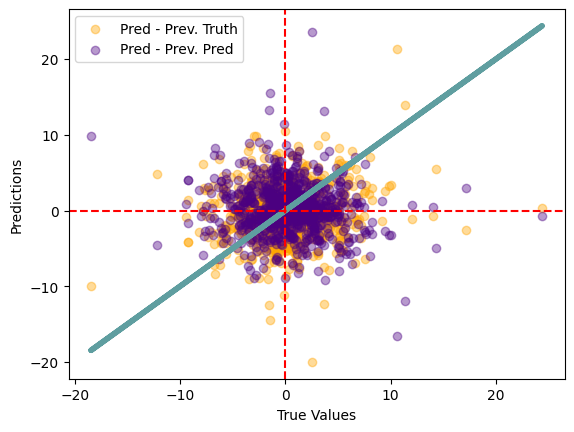

In [43]:
y2 = y2.reshape(-1)
print(y2.shape,m.shape)
print(m.shape)
true_pct_changes = (np.diff(y2) / y2[:-1]) * 100
pred_pct_changes = ((m - y2) / y2) * 100 
pred_pct_changes2 = (np.diff(m) / m[:-1]) * 100

# y3 = y3.reshape(-1)
# true_pct_changes = (np.diff(y3) / y3[:-1]) * 100
# pred_pct_changes = ((m_test - y3) / y3) * 100 


print(true_pct_changes.shape)
print(pred_pct_changes.shape)
plt.figure()
plt.scatter(true_pct_changes, pred_pct_changes[:-1],color='orange',alpha=.4,label='Pred - Prev. Truth')
plt.scatter(true_pct_changes, pred_pct_changes2,color='indigo',alpha=.4,label='Pred - Prev. Pred')
plt.plot(true_pct_changes, true_pct_changes,lw=4,color='cadetblue')
plt.axhline(y=0,ls='--',color='red')
plt.axvline(x=0,ls='--',color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.show()

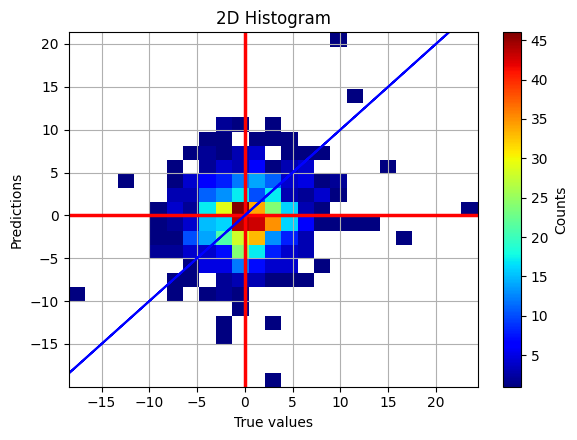

In [44]:
plt.figure(figsize=(6, 4.5))
plt.hist2d(true_pct_changes, pred_pct_changes[:-1], bins=25, cmap='jet',cmin=1)#,range=[[-2, 2], [-2, 2]]
# plt.hist2d(true_pct_changes, pred_pct_changes2, bins=25, cmap='jet',range=[[-2, 2], [-2, 2]],cmin=1)
plt.colorbar(label='Counts')
plt.xlabel('True values')
plt.ylabel('Predictions')
plt.title('2D Histogram')
plt.axhline(y=0, color='red', linestyle='-',lw=2.5)   # Horizontal line at y=0
plt.axvline(x=0, color='red', linestyle='-',lw=2.5)  # Vertical line at x=0
plt.plot(true_pct_changes, true_pct_changes, color='blue')   
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(np.sign(true_pct_changes), np.sign(pred_pct_changes[:-1]), labels=[1, -1])
# conf_matrix = confusion_matrix(np.sign(true_pct_changes), np.sign(pred_pct_changes2), labels=[1, -1])
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[189 261]
 [175 212]]


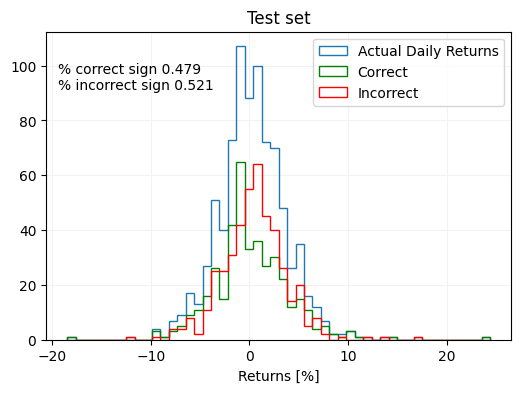

In [46]:

same_sign_indices = np.where(np.sign(true_pct_changes) == np.sign(pred_pct_changes[:-1]))
diff_sign_indices = np.where(np.sign(true_pct_changes) != np.sign(pred_pct_changes[:-1]))

plt.figure(figsize=(6,4))
_, bins, _ = plt.hist(true_pct_changes,bins=50,histtype='step',label='Actual Daily Returns')
plt.hist(true_pct_changes[same_sign_indices],bins=bins,histtype='step',color='green',label='Correct')
plt.hist(true_pct_changes[diff_sign_indices],bins=bins,histtype='step',color='red',label='Incorrect')
plt.grid(color='0.95')
plt.xlabel('Returns [%]')
plt.title('Test set')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
text_x = x_min + 0.025 * (x_max - x_min)
text_y = y_max - 0.1 * (y_max - y_min)
plt.text(text_x, text_y, '% correct sign {:.3f}\n% incorrect sign {:.3f}'.format(len(true_pct_changes[same_sign_indices])/len(true_pct_changes),
                                                                                 len(true_pct_changes[diff_sign_indices])/len(true_pct_changes)), ha='left', va='top')
plt.legend()
plt.show()

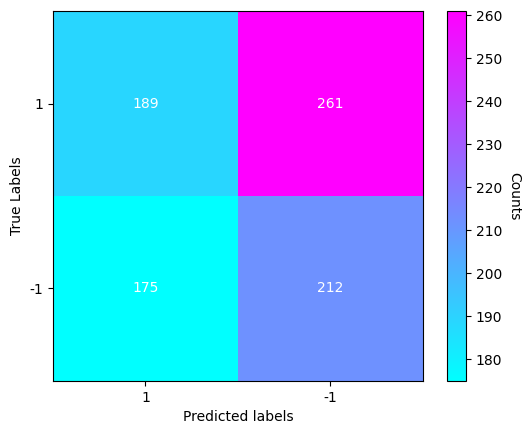

In [47]:
fig, ax = plt.subplots()
im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.cool)

cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Counts', rotation=-90, va="bottom")
ax.set(xlabel='Predicted labels',ylabel='True Labels')
ax.set_xticks([0,1])
ax.set_xticklabels(['1', '-1'])
ax.set_yticks([0,1])
ax.set_yticklabels(['1', '-1'])
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, str(conf_matrix[i, j]), ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.show()

In [48]:
#one day test
one_day_input = np.lib.stride_tricks.sliding_window_view(df.iloc[-12:,1].values, sequence_length)[:-1]
y4 = np.array(df.iloc[sequence_length-12:,1]).astype(np.float32)


print(one_day_input)
print(y4)

[[429.97000122 426.52999878 426.92001343 438.07998657 430.45001221
  430.25       422.08999634 406.32000732 418.76000977 411.17001343]
 [426.52999878 426.92001343 438.07998657 430.45001221 430.25
  422.08999634 406.32000732 418.76000977 411.17001343 408.22000122]]
[408.22 423.02]


In [49]:
#aleatoric uncertainty +- sigma
#epistemic uncertainty 100 predict calls
yhats_test = [model(one_day_input) for _ in range(100)]

means = []
stds = []
avgm = np.zeros_like(one_day_input[...,0])
for i, yhat in enumerate(yhats_test):
  means.append(yhat.mean())
  stds.append(yhat.stddev())
  m_test = np.squeeze(yhat.mean())
  s_test = np.squeeze(yhat.stddev())
  avgm += m_test/len(yhats_test)

mean_array = np.mean(np.array(means),axis=0)
std_array = np.mean(np.array(stds),axis=0)
print(mean_array)
print(std_array)
print(avgm)
# print(means)
print('Pred: ',m_test,'+-',s_test)
upper_bound = m_test + s_test
lower_bound = m_test - s_test
# print(m_test, '+-', s_test)
print('Truth: ',y4)

[[410.37476]
 [406.42825]]
[[11.973639]
 [11.85845 ]]
[410.37487555 406.42825651]
Pred:  [410.5219  406.57385] +- [11.921695 11.807029]
Truth:  [408.22 423.02]


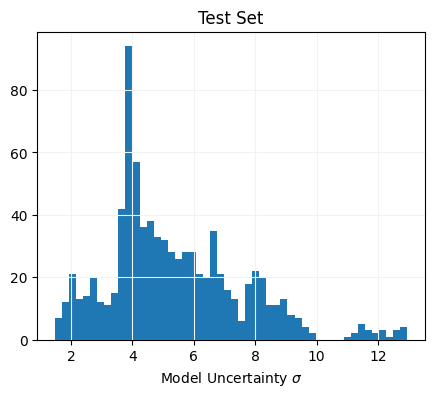

In [50]:
plt.figure(figsize=(5,4))
plt.hist(s,bins=50)
plt.xlabel('Model Uncertainty $\sigma$')
plt.title('Test Set')
plt.grid(color='0.95')
plt.show()

(838,) (838,) (838,)
(261,) (261,) (261,)


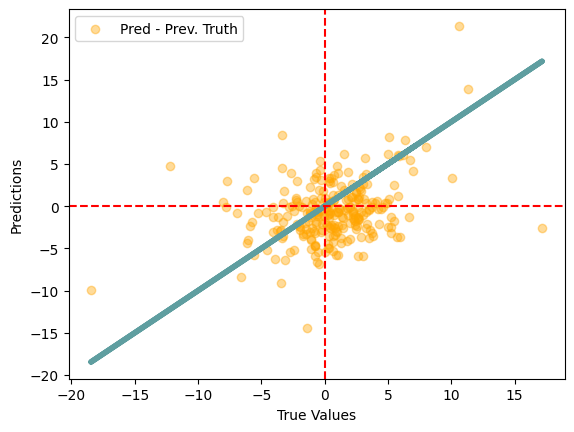

[  7.002894   -3.9436226  -2.6528594  -7.7431984   6.372223   -5.5959806
 -12.236785   11.340206  -18.452085   10.626279 ]
[ 4.1698055 -6.2374663  3.9849396  2.969843   7.8905916 -5.744454
  4.800993  13.913602  -9.898439  21.349945 ]


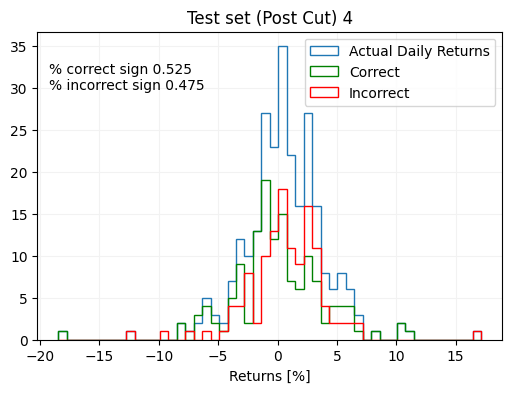

In [51]:
true_pct_changes = (np.diff(y2) / y2[:-1]) * 100
pred_pct_changes = (((m - y2) / y2) * 100 )[:-1]
pred_pct_changes2 = (np.diff(m) / m[:-1]) * 100
print(pred_pct_changes.shape,pred_pct_changes2.shape,true_pct_changes.shape)

sig_cut = 4
true_pct_changes_sig = true_pct_changes[s[:-1]<sig_cut]
pred_pct_changes_sig = pred_pct_changes[s[:-1]<sig_cut]
pred_pct_changes2_sig = pred_pct_changes2[s[:-1]<sig_cut]
print(pred_pct_changes_sig.shape,pred_pct_changes2_sig.shape,true_pct_changes_sig.shape)
plt.figure()
plt.scatter(true_pct_changes_sig, pred_pct_changes_sig,color='orange',alpha=.4,label='Pred - Prev. Truth')
# plt.scatter(true_pct_changes_sig, pred_pct_changes2_sig,color='indigo',alpha=.4,label='Pred - Prev. Pred')
plt.plot(true_pct_changes_sig, true_pct_changes_sig,lw=4,color='cadetblue')
plt.axhline(y=0,ls='--',color='red')
plt.axvline(x=0,ls='--',color='red')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.show()

print(true_pct_changes[:10])
print(pred_pct_changes[:10])
same_sign_indices = np.where(np.sign(true_pct_changes_sig) == np.sign(pred_pct_changes_sig))
diff_sign_indices = np.where(np.sign(true_pct_changes_sig) != np.sign(pred_pct_changes_sig))

plt.figure(figsize=(6,4))
_, bins, _ = plt.hist(true_pct_changes_sig,bins=50,histtype='step',label='Actual Daily Returns')
plt.hist(true_pct_changes[same_sign_indices],bins=bins,histtype='step',color='green',label='Correct')
plt.hist(true_pct_changes[diff_sign_indices],bins=bins,histtype='step',color='red',label='Incorrect')
plt.grid(color='0.95')
plt.xlabel('Returns [%]')
plt.title(f'Test set (Post Cut) {sig_cut}')
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
text_x = x_min + 0.025 * (x_max - x_min)
text_y = y_max - 0.1 * (y_max - y_min)
plt.text(text_x, text_y, '% correct sign {:.3f}\n% incorrect sign {:.3f}'.format(len(true_pct_changes_sig[same_sign_indices])/len(true_pct_changes_sig),
                                                                                 len(true_pct_changes_sig[diff_sign_indices])/len(true_pct_changes_sig)), ha='left', va='top')
plt.legend()
plt.show()